In [31]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_modules import View
from nn_models import LeNet, aliG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.4.1


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

## Loading the data (MNIST)

In [4]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [5]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 1000


In [6]:
train_target[0].type()

'torch.LongTensor'

## 1) LeNet with disjoint trainset and testset

In [7]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [8]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.02164649           0.285      0.00197844           0.372
10                   0.00203751           0.941      0.00047562           0.854
20                   0.00051393           0.989      0.00026236           0.916
30                   0.00012660           1.000      0.00019355           0.924
40                   0.00006353           1.000      0.00019026           0.930
49                   0.00004177           1.000      0.00019540           0.927
*******************************************************************************


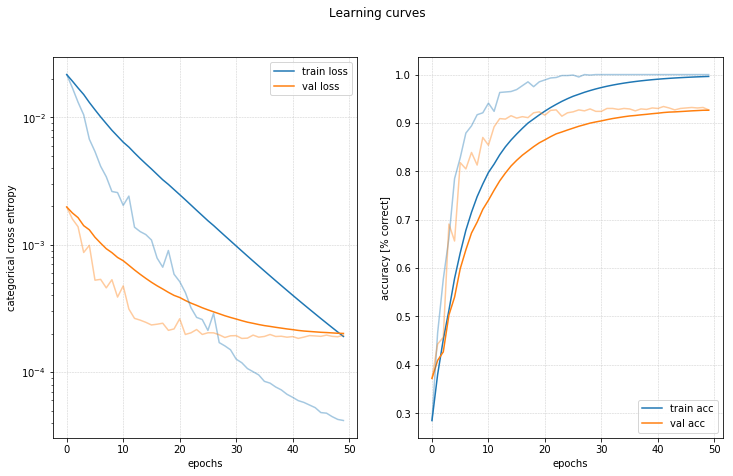

In [9]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.08

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [10]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [11]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [12]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -0.3898,  -1.4913,  -1.0028,   8.9078, -14.0111,  18.0963,  -4.4865,
          -4.7906,   4.2536,  -4.6783],
        [ 16.6722,  -8.6269,  -0.1464,  -7.1382,  -8.4282,   4.8117,   0.9629,
           2.8255,  -6.4829,   5.7796],
        [ -8.9700,  -2.2152,   3.4807,   0.8394,  15.2996,  -4.9787,  -3.5008,
           2.9956,  -6.3508,   4.9092],
        [ -4.5600,  14.7261,   2.5503,  -5.6928,   1.1948,  -5.4162,   0.4755,
           2.5405,   3.1277,  -7.0584],
        [ -5.9365,  -2.2492,  -6.6985,  -1.9188,   7.7527,  -2.3203,  -9.1350,
           3.6957,   2.5138,  16.1510],
        [ -0.8614,  -3.8528,   9.8704,   1.8430,  -6.5355,  -0.8709,  -3.8319,
           2.5337,   3.4160,   1.3893],
        [ -9.4520,  11.6048,   0.0603,  -0.2215,   0.2854,   0.7291,  -1.0912,
          -0.1418,   3.8729,  -3.7710],
        [ -3.7611,  -3.7604,   6.9736,  20.6789, -15.2361,   3.4589, -14.6913,
          -1.2857,   6.1121,   2.1532],
        [ -7.2032,  12.2383,  -1.6978,  -2.5706,

In [13]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [14]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample

In [15]:
#Size of input vector can be changed
modelG = aliG(142)

In [16]:
debug_layers_dims(modelG, [1, 1, 142])

******************** Debugging layers sizes: ********************
input_shape= (_,1,142)
------------------
Conv1d(1, 32, kernel_size=(8,), stride=(1,))
(_,1,142) --> (_,32,135)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,32,135) --> (_,32,67)
------------------
Conv1d(32, 128, kernel_size=(5,), stride=(1,))
(_,32,67) --> (_,128,63)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,128,63) --> (_,128,31)
------------------
Conv1d(128, 16, kernel_size=(3,), stride=(1,))
(_,128,31) --> (_,16,29)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,16,29) --> (_,16,14)
------------------
View(_, [-1])
(_,16,14) --> (_,224)
------------------
Linear(in_features=224, out_features=100, bias=True)
(_,224) --> (_,100)
------------------
Linear(in_features=100, out_features=32, bias=True)
(_,100) --> (_,32)
------------------
Linear(in_features=32, out_

tensor([[0.0396],
        [0.0387]], grad_fn=<ThAddmmBackward>)

In [17]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [18]:
layer = model.fc1
layer_name = "fc1"

In [19]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = generate_dataset_g(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7)

In [20]:
g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)

In [21]:
g_train_target.type()

'torch.LongTensor'

In [22]:
g_train_input.shape

torch.Size([1400, 1, 200])

In [23]:
g_train_target

tensor([1, 1, 1,  ..., 0, 0, 0])

In [24]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of input vector :", size_input_vector)

size of input vector : 200


In [35]:
modelG = aliG(size_input_vector)

In [39]:
modelG(g_test_dataset[0][0:10]).argmax(1).type()

'torch.LongTensor'

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.00049510           0.502      0.00115525           0.500
0                    0.00049510           0.502      0.00115525           0.500
*******************************************************************************


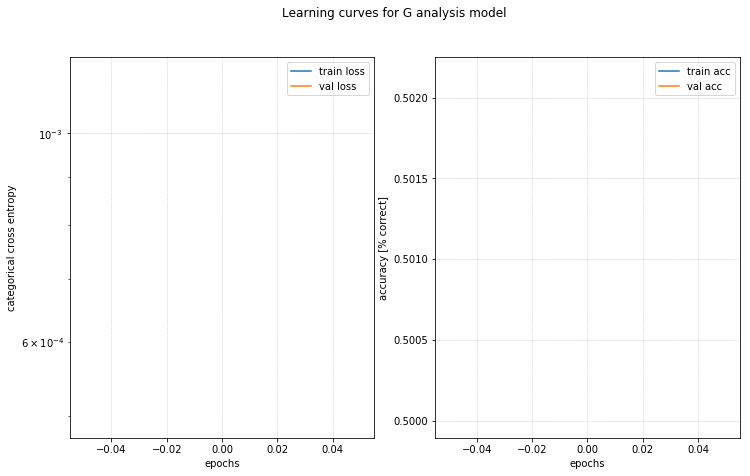

In [40]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss()
learning_rate = 0.005

mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=1, batch_size=None, verbose=1)
mt.plot_training("Learning curves for G analysis model")

In [30]:
(Tensor([0.1, -1, -10000, 0.49999, 0.5, 0.50000000001, 10000, 1, -10000]) >= 0.5).float()

tensor([0., 0., 0., 0., 1., 1., 1., 1., 0.])